In [12]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import fashion_mnist
from sklearn.preprocessing import OneHotEncoder

In [3]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ishaan_maheshwari (ishaan_maheshwari-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
wandb.init(project='assignment-1', entity="ishaan_maheshwari-indian-institute-of-technology-madras" )

In [30]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# y_train_one_hot = np.eye(10)[y_train]
# y_test_one_hot = np.eye(10)[y_test]

ohe = OneHotEncoder(sparse_output=False)
y_train, y_test = ohe.fit_transform(y_train.reshape(-1, 1)), ohe.transform(y_test.reshape(-1, 1))

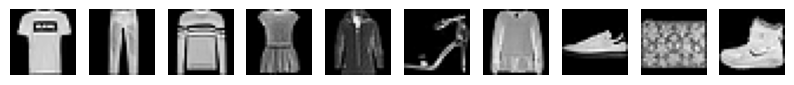

In [18]:
# Visualize Data
fig, axes = plt.subplots(1, 10, figsize=(10, 2))
for i in range(10):
    sample = X_train[y_train == i][0].reshape(28, 28)
    axes[i].imshow(sample, cmap='gray')
    axes[i].axis('off')
plt.show()

wandb.log({"sample_images": [wandb.Image(sample) for sample in X_train[:10].reshape(-1, 28, 28)]})

In [29]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_layers, output_size, activation='relu', weight_init='random', l2_lambda=0):
        self.layers = [input_size] + hidden_layers + [output_size]
        self.activation = activation
        self.l2_lambda = l2_lambda
        self.weights = []
        self.biases = []
        self.velocities_w = []
        self.velocities_b = []
        self.m_w = []
        self.m_b = []
        self.v_w = []
        self.v_b = []
        self.t = 0
        
        for i in range(len(self.layers) - 1):
            if weight_init == 'random':
                self.weights.append(np.random.randn(self.layers[i], self.layers[i+1]) * 0.01)
            elif weight_init == 'xavier':
                self.weights.append(np.random.randn(self.layers[i], self.layers[i+1]) * np.sqrt(1.0 / self.layers[i]))
            self.biases.append(np.zeros((1, self.layers[i+1])))
            
            # Initialize optimizer variables
            self.velocities_w.append(np.zeros_like(self.weights[-1]))
            self.velocities_b.append(np.zeros_like(self.biases[-1]))
            self.m_w.append(np.zeros_like(self.weights[-1]))
            self.m_b.append(np.zeros_like(self.biases[-1]))
            self.v_w.append(np.zeros_like(self.weights[-1]))
            self.v_b.append(np.zeros_like(self.biases[-1]))
    
    def activate(self, x, deriv=False):
        if self.activation == 'relu':
            return np.maximum(0, x) if not deriv else (x > 0).astype(float)
        elif self.activation == 'sigmoid':
            sig = 1 / (1 + np.exp(-x))
            return sig if not deriv else sig * (1 - sig)
        elif self.activation == 'tanh':
            tanh = np.tanh(x)
            return tanh if not deriv else 1 - tanh**2
    
    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def forward(self, X):
        self.a = [X]
        self.z = []
        for i in range(len(self.weights) - 1):
            z = np.dot(self.a[-1], self.weights[i]) + self.biases[i]
            self.z.append(z)
            self.a.append(self.activate(z))
        z = np.dot(self.a[-1], self.weights[-1]) + self.biases[-1]
        self.z.append(z)
        self.a.append(self.softmax(z))
        return self.a[-1]
    
    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        loss = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
        if self.l2_lambda:
            reg_loss = self.l2_lambda * sum(np.sum(w**2) for w in self.weights) / (2 * m)
            loss += reg_loss
        return loss
    
    def backward(self, X, y_true, lr=0.01, optimizer='sgd', beta1=0.9, beta2=0.999, eps=1e-8, momentum=0.9):
        grads_w, grads_b = [], []
        m = y_true.shape[0]
        dz = self.a[-1] - y_true
        self.t += 1
        
        for i in reversed(range(len(self.weights))):
            dw = np.dot(self.a[i].T, dz) / m + (self.l2_lambda * self.weights[i] / m if self.l2_lambda else 0)
            db = np.sum(dz, axis=0, keepdims=True) / m
            grads_w.insert(0, dw)
            grads_b.insert(0, db)
            if i > 0:
                dz = np.dot(dz, self.weights[i].T) * self.activate(self.z[i-1], deriv=True)
        
        # Optimizers
        for i in range(len(self.weights)):
            if optimizer == 'sgd':
                self.weights[i] -= lr * grads_w[i]
                self.biases[i] -= lr * grads_b[i]
            elif optimizer == 'momentum':
                self.velocities_w[i] = momentum * self.velocities_w[i] - lr * grads_w[i]
                self.velocities_b[i] = momentum * self.velocities_b[i] - lr * grads_b[i]
                self.weights[i] += self.velocities_w[i]
                self.biases[i] += self.velocities_b[i]
            elif optimizer == 'adam' or optimizer == 'nadam':
                self.m_w[i] = beta1 * self.m_w[i] + (1 - beta1) * grads_w[i]
                self.m_b[i] = beta1 * self.m_b[i] + (1 - beta1) * grads_b[i]
                self.v_w[i] = beta2 * self.v_w[i] + (1 - beta2) * (grads_w[i] ** 2)
                self.v_b[i] = beta2 * self.v_b[i] + (1 - beta2) * (grads_b[i] ** 2)
                m_w_hat = self.m_w[i] / (1 - beta1 ** self.t)
                m_b_hat = self.m_b[i] / (1 - beta1 ** self.t)
                v_w_hat = self.v_w[i] / (1 - beta2 ** self.t)
                v_b_hat = self.v_b[i] / (1 - beta2 ** self.t)
                self.weights[i] -= lr * m_w_hat / (np.sqrt(v_w_hat) + eps)
                self.biases[i] -= lr * m_b_hat / (np.sqrt(v_b_hat) + eps)

    def train(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=32, lr=0.01, optimizer='adam'):
        for epoch in range(epochs):
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                self.forward(X_batch)
                self.backward(X_batch, y_batch, lr, optimizer)
            
            y_pred = self.forward(X_val)
            loss = self.compute_loss(y_val, y_pred)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

In [31]:
# Train the model
nn = NeuralNetwork(input_size=784, hidden_layers=[128, 64], output_size=10)
nn.train(X_train, y_train, X_test, y_test, epochs=10, batch_size=32, lr=0.01, optimizer='adam')

Epoch 1/10, Loss: 0.4668
Epoch 2/10, Loss: 0.4757
Epoch 3/10, Loss: 0.5105
Epoch 4/10, Loss: 0.4250
Epoch 5/10, Loss: 0.4261
Epoch 6/10, Loss: 0.4262
Epoch 7/10, Loss: 0.4251
Epoch 8/10, Loss: 0.4296
Epoch 9/10, Loss: 0.4713
Epoch 10/10, Loss: 0.4039
